## Setup

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt

import random
import numpy as np
import pandas as pd
import tensorflow as tf
import isuelogit as isl
import seaborn as sns
from datetime import datetime

In [2]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

main dir: /Users/pablo/github/gisuelogit


In [3]:
# Internal modules
from src.gisuelogit.visualizations import plot_predictive_performance, plot_heatmap_demands, plot_convergence_estimates
from src.gisuelogit.models import UtilityParameters, GISUELOGIT, AETSUELOGIT, NGD, BPRParameters, ODParameters, compute_rr, compute_insample_outofsample_error
from src.gisuelogit.networks import load_k_shortest_paths, build_tntp_network, Equilibrator, ColumnGenerator
from src.gisuelogit.etl import get_design_tensor, get_y_tensor, simulate_suelogit_data, add_period_id
from src.gisuelogit.descriptive_statistics import mse, btcg_mse, mnrmse, nrmse

In [4]:
# Seed for reproducibility
_SEED = 2023
np.random.seed(_SEED)
random.seed(_SEED)
tf.random.set_seed(_SEED)

## Build network

In [5]:
network_name = 'SiouxFalls'
tntp_network = build_tntp_network(network_name=network_name)

## Read OD matrix

In [6]:
Q = isl.reader.read_tntp_od(network_name=network_name)
tntp_network.load_OD(Q=Q)

# Assume the historic OD matrix has some random deviation respect to true matrix
Q_historic = isl.factory.random_disturbance_Q(tntp_network.Q.copy(), sd=np.mean(tntp_network.Q) * 0.1)

Reading Q from external file
Matrix Q (24, 24) read in 0.3[s]                        

360600.0 trips were loaded among 528 o-d pairs
Mean of nonzero entries in the original demand matrix:  683.0
Mean absolute difference between the nonzero entries of the noisy and original: 50.6
Approximated proportion change: 7.4%


In [7]:
Q

array([[   0.,  100.,  100.,  500.,  200.,  300.,  500.,  800.,  500.,
        1300.,  500.,  200.,  500.,  300.,  500.,  500.,  400.,  100.,
         300.,  300.,  100.,  400.,  300.,  100.],
       [ 100.,    0.,  100.,  200.,  100.,  400.,  200.,  400.,  200.,
         600.,  200.,  100.,  300.,  100.,  100.,  400.,  200.,    0.,
         100.,  100.,    0.,  100.,    0.,    0.],
       [ 100.,  100.,    0.,  200.,  100.,  300.,  100.,  200.,  100.,
         300.,  300.,  200.,  100.,  100.,  100.,  200.,  100.,    0.,
           0.,    0.,    0.,  100.,  100.,    0.],
       [ 500.,  200.,  200.,    0.,  500.,  400.,  400.,  700.,  700.,
        1200., 1400.,  600.,  600.,  500.,  500.,  800.,  500.,  100.,
         200.,  300.,  200.,  400.,  500.,  200.],
       [ 200.,  100.,  100.,  500.,    0.,  200.,  200.,  500.,  800.,
        1000.,  500.,  200.,  200.,  100.,  200.,  500.,  200.,    0.,
         100.,  100.,  100.,  200.,  100.,    0.],
       [ 300.,  400.,  300.,  400.,

In [8]:
Q_historic

array([[   0.    ,  144.5537,   79.6859,  437.2787,  214.7903,  293.6044,
         428.5503,  966.177 ,  590.1879, 1306.1917,  304.5791,  132.6053,
         479.611 ,  235.1735,  473.3106,  435.5577,  367.3348,   73.5336,
         293.7869,  213.5901,  118.9004,  335.2924,  205.9574,   13.6317],
       [  87.2003,    0.    ,  140.1997,  188.6577,  148.3147,  446.4225,
         282.9357,  427.5012,  165.0748,  658.039 ,  162.392 ,    4.8574,
         431.3015,  155.8781,  199.9468,  360.0108,  129.0665,    0.    ,
         141.1057,  137.2987,    0.    ,   49.2205,    0.    ,    0.    ],
       [  81.1853,  163.1295,    0.    ,  131.9015,    0.    ,  321.3242,
          21.5256,  223.2129,  128.5008,  157.0296,  299.9485,  350.1796,
           0.    ,  182.0746,    1.1181,  147.3698,   89.6384,    0.    ,
           0.    ,    0.    ,    0.    ,    0.    ,  128.3433,    0.    ],
       [ 503.2011,  185.0964,  186.9778,    0.    ,  525.1233,  411.4671,
         477.3681,  681.7321,  701.

## Read paths

In [9]:
load_k_shortest_paths(network=tntp_network, k=3, update_incidence_matrices=True)

Generating at most 3 paths per od
1584 paths were generated among 528 od pairs in 1.0 [s]

1584 paths were loaded in the network
Matrix D (76, 1584) generated in 1.7[s]               

Matrix M (528, 1584) generated in 0.3[s]               

Matrix C (1584, 1584) generated in 0.0[s]               



## Read data

In [10]:
# Synthethic data which was generated under the assumption of path sets of size 2.
df = pd.read_csv(
    main_dir + '/output/network-data/' + tntp_network.key + '/links/' + tntp_network.key + '-link-data.csv')

In [11]:
df

,period,link_key,tt_sd,s,counts,true_counts,true_traveltime,traveltime
0,1,"(0, 1, '0')",0.321988,0.018341,7515.076333,6139.079386,6.002841,7.341932
1,1,"(0, 2, '0')",0.890422,0.603453,7034.842500,5758.656079,4.002199,3.837664
2,1,"(1, 0, '0')",0.588052,0.921806,3773.154711,5495.220725,6.001824,6.191882
3,1,"(1, 5, '0')",0.126596,0.281364,7747.540107,7906.517521,9.849676,9.656309
4,1,"(2, 0, '0')",0.141341,0.834801,8810.477533,6402.514740,4.003361,4.124810
...,...,...,...,...,...,...,...,...
7595,100,"(22, 21, '0')",0.611373,0.570475,9375.990717,10318.046697,14.880809,14.390547
7596,100,"(22, 23, '0')",0.419611,0.377307,6450.125269,7118.491402,3.158053,1.063308
7597,100,"(23, 12, '0')",0.091677,0.284513,7916.670229,10851.756311,16.383733,16.940392
7598,100,"(23, 20, '0')",0.534854,0.202666,11741.293201,10705.049806,13.374851,13.490250


## Utility function

In [12]:
features_Z = ['tt_sd', 's']

n_sparse_features = 0
features_sparse = ['k' + str(i) for i in np.arange(0, n_sparse_features)]
features_Z.extend(features_sparse)

## Training and validation sets

In [13]:
n_timepoints = len(df.period.unique())
n_links = len(tntp_network.links)

# Add free flow travel times
df['tt_ff'] = np.tile([link.bpr.tf for link in tntp_network.links], n_timepoints)

traveltime_data = get_design_tensor(y=df['traveltime'], n_links=n_links, n_timepoints = n_timepoints)
flow_data = get_y_tensor(y=df[['counts']], n_links=n_links, n_timepoints = n_timepoints)

df = add_period_id(df)

Y = tf.concat([traveltime_data, flow_data], axis=2)
X = get_design_tensor(Z=df[features_Z + ['period_id']], n_links=n_links, n_timepoints = n_timepoints)

X_train, X_test, Y_train, Y_test = X, None, Y, None

2023-02-13 11:45:32.398008: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Configuration

In [14]:
_LR = 1e-2
_BATCH_SIZE = 16 #None
_EPOCHS_PRINT_INTERVAL = 100

_XTICKS_SPACING = 500

_LOSS_METRIC = mse
#_LOSS_METRIC  = btcg_mse
#_LOSS_METRIC  = mnrmse
#_LOSS_METRIC  = nrmse

_LOSS_WEIGHTS ={'od': 1, 'tt': 1, 'flow': 1, 'eq_flow': 1,'ntrips': 0, 'prop_od': 0}

# Without momentum but with separate equilibrium stage
# _EPOCHS = {'learning': 10, 'equilibrium': 4}
# _EPOCHS = {'learning': 1000, 'equilibrium': 0}
_EPOCHS = {'learning': 2500, 'equilibrium': 500}
_MOMENTUM_EQUILIBRIUM = 0.999
_RELATIVE_GAP = 1e-10

# With momentum
# _EPOCHS = {'learning': 2500, 'equilibrium': 0}
# _MOMENTUM_EQUILIBRIUM = 0.999

# I may set a specific relative gap for equilibrium
# _RELATIVE_GAP = 1e-7

# ODLUE cannot recover true VOT when no historic OD is provided in loss function
#_LOSS_WEIGHTS ={'od': 0, 'tt': 1, 'flow': 1, 'eq_flow': 1}

print(f"_LOSS_WEIGHTS: {_LOSS_WEIGHTS}, _MOMENTUM_EQUILIBRIUM: {_MOMENTUM_EQUILIBRIUM}, "
      f"epochs { _EPOCHS}")

_LOSS_WEIGHTS: {'od': 1, 'tt': 1, 'flow': 1, 'eq_flow': 1, 'ntrips': 0, 'prop_od': 0}, _MOMENTUM_EQUILIBRIUM: 0.999, epochs {'learning': 2500, 'equilibrium': 500}


## Models

In [15]:
list_models = ['equilibrium', 'lue', 'ode', 'ode-nosuelogit', 'lpe',
               'odlue', 'odlulpe', 'odlulpe-no-equilibrium', 'tvodlulpe']

run_model = dict.fromkeys(list_models,True)
#run_model = dict.fromkeys(list_models, False)

# run_model['equilibrium'] = True
# run_model['lue'] = True
# run_model['ode'] = True
# run_model['lpe'] = True
# run_model['odlue'] = True
# run_model['odlulpe'] = True


In [16]:
train_results_dfs = {}
val_results_dfs = {}

### Model 1: Equilibrium

Gradient based SUELOGIT

Epoch: 0/2500, n_periods: 1,  n_timepoints: 100, coverage t, x: [0.75 0.75]
0: train_loss=7.7e+07, val_loss=0, train_loss tt=3.7e+03, val_loss tt=0, train_loss flow=1.4e+07, val_loss flow=0, theta = [-1.  -1.3 -3. ], avg rr = 1.30, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss prop od=nan, loss ntrips=0, total trips=[3.6e+05], lambda eq=1, relative x=0.82, relative gap=1e-10, train flow equilibrium loss=7.7e+07, time: 0.4

Epoch: 1/2500, n_periods: 1,  n_timepoints: 100, coverage t, x: [0.75 0.75]
1: train_loss=7.7e+07, val_loss=0, train_loss tt=3.7e+03, val_loss tt=0, train_loss flow=1.4e+07, val_loss flow=0, theta = [-1.  -1.3 -3. ], avg rr = 1.30, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss prop od=nan, loss ntrips=0, total trips=[3.6e+05], lambda eq=1, relative x=0.82, relative gap=0.002, train flow equilibrium loss=7.7e+07, time: 0.9

Epoch: 100/2500, n_periods: 1,  n_timepoints: 100, cove

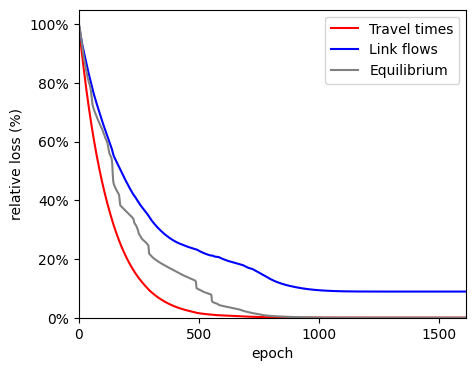

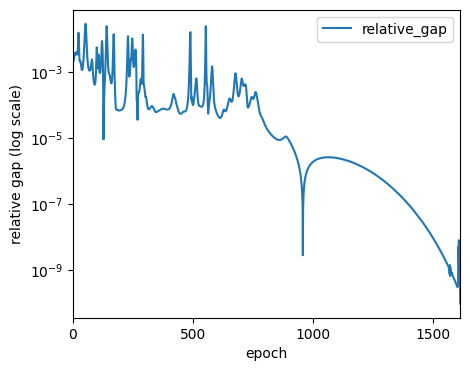

In [17]:
if run_model['equilibrium']:

    # _RELATIVE_GAP = 1e-8

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    print('Gradient based SUELOGIT')

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           initial_values={'tt': -1, 'tt_sd': -1.3, 's': -3, 'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(tntp_network.links)},
                                           trainables={'psc_factor': False, 'fixed_effect': False
                                               , 'tt': False, 'tt_sd': False, 's': False},
                                           )

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 4},
                                   # initial_values={'alpha': 1, 'beta': 1},
                                   trainables=dict.fromkeys(['alpha', 'beta'], False),
                                   )

    od_parameters = ODParameters(key='od',
                                 initial_values= isl.networks.denseQ(Q).flatten(),
                                 # historic_values={0: isl.networks.denseQ(Q_historic).flatten()},
                                 trainable=False)

    equilibrator = Equilibrator(
        network=tntp_network,
        # paths_generator=paths_generator,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    suelogit = GISUELOGIT(
        key='suelogit',
        # endogenous_flows=True,
        network=tntp_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        # column_generator=column_generator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters
    )

    train_results_dfs['suelogit'], val_results_dfs['suelogit'] = suelogit.train(
        X_train, Y_train, X_test, Y_test,
        # generalization_error={'train': False, 'validation': True},
        # loss_metric = mse,
        loss_metric=_LOSS_METRIC,
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        loss_weights={'od': 0, 'theta': 0, 'tt': 0, 'flow': 0, 'eq_flow': 1},
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval = _EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    train_results_estimates, train_results_losses = suelogit.split_results(results=train_results_dfs['suelogit'])
    val_results_estimates, val_results_losses = suelogit.split_results(results=val_results_dfs['suelogit'])

    plot_predictive_performance(train_losses=train_results_dfs['suelogit'], val_losses=val_results_dfs['suelogit'],xticks_spacing= _XTICKS_SPACING)

    fig, ax = plot_convergence_estimates(
        estimates=train_results_losses.assign(
            relative_gap = np.abs(train_results_losses['relative_gap']))[['epoch','relative_gap']],
    xticks_spacing= _XTICKS_SPACING)

    ax.set_yscale('log')
    ax.set_ylabel('relative gap (log scale)')

    plt.show()

## Model 2: ODE with historic OD


 ODE: OD estimation with historic OD

Epoch: 0/2500, n_periods: 1,  n_timepoints: 100, coverage t, x: [0.75 0.75]
0: train_loss=9.1e+07, val_loss=0, train_loss tt=3.7e+03, val_loss tt=0, train_loss flow=1.4e+07, val_loss flow=0, theta = [-1.  -1.3 -3. ], avg rr = 1.30, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss prop od=3.9e+03, loss ntrips=0, total trips=[3.6e+05], lambda eq=1, relative x=0.82, relative gap=1e-10, train flow equilibrium loss=7.7e+07, time: 0.3

Epoch: 1/2500, n_periods: 1,  n_timepoints: 100, coverage t, x: [0.75 0.75]
1: train_loss=2.3e+07, val_loss=0, train_loss tt=3.7e+03, val_loss tt=0, train_loss flow=1.4e+07, val_loss flow=0, theta = [-1.  -1.3 -3. ], avg rr = 1.30, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss prop od=4e+03, loss ntrips=0, total trips=[3.6e+05], lambda eq=0.25, relative x=0.81, relative gap=0.017, train flow equilibrium loss=7.6e+07, time: 0.9

Epoch: 100/2500, n_periods: 1,  

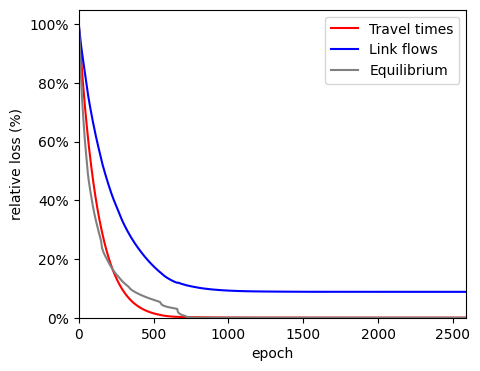

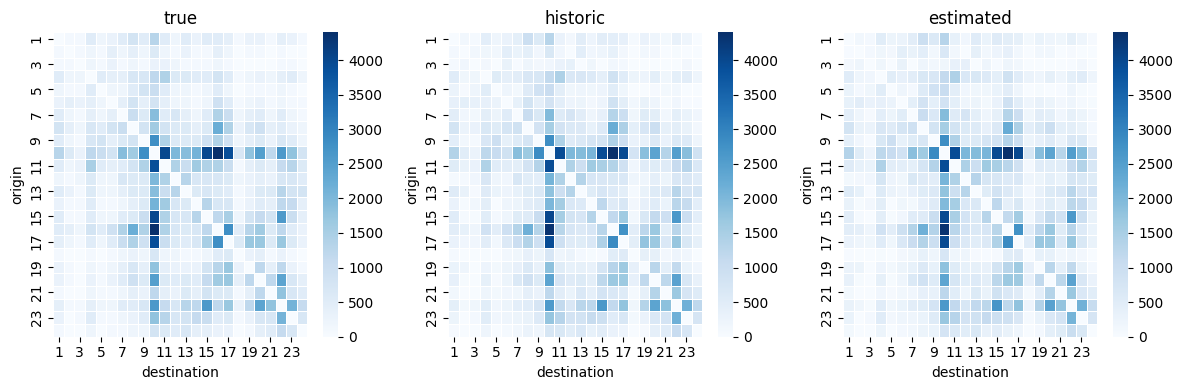

In [18]:
if run_model['ode']:
    print('\n ODE: OD estimation with historic OD')

    # _RELATIVE_GAP = 1e-9

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)
    # optimizer = tf.keras.optimizers.Adagrad(learning_rate=_LR)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           initial_values={'tt': -1, 'tt_sd': -1.3, 's': -3, 'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(tntp_network.links)},
                                           trainables={'psc_factor': False, 'fixed_effect': False
                                               , 'tt': False, 'tt_sd': False, 's': False},
                                           )

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 4},
                                   trainables=dict.fromkeys(['alpha', 'beta'], False),
                                   )

    od_parameters = ODParameters(key='od',
                                 # initial_values=tntp_network.q.flatten(),
                                 initial_values= isl.networks.denseQ(Q).flatten(),
                                 historic_values={0: isl.networks.denseQ(Q_historic).flatten()},
                                 # total_trips = {0: np.sum(Q_historic)},
                                 # historic_values={0: tntp_network.q.flatten()},
                                 trainable=True)

    equilibrator = Equilibrator(
        network=tntp_network,
        # paths_generator=paths_generator,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    ode = GISUELOGIT(
        key='ode',
        network=tntp_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    train_results_dfs['ode'], val_results_dfs['ode'] = ode.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        loss_metric=_LOSS_METRIC,
        # generalization_error={'train': False, 'validation': True},
        loss_weights=dict(_LOSS_WEIGHTS),
        momentum_equilibrium=_MOMENTUM_EQUILIBRIUM,
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    plot_predictive_performance(train_losses=train_results_dfs['ode'], val_losses=val_results_dfs['ode'],
                                show_validation=False,
                                xticks_spacing=_XTICKS_SPACING)

    Qs = {'true': tntp_network.OD.Q_true, 'historic': Q_historic, 'estimated': tf.sparse.to_dense(ode.Q).numpy()}

    plot_heatmap_demands(Qs=Qs, vmin=np.min(Qs['true']), vmax=np.max(Qs['true']), subplots_dims=(1, 3), figsize=(12, 4))

    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(ode.theta.numpy())))}")
    print(f"alpha = {ode.alpha: 0.2f}, beta  = {ode.beta: 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(ode.q - tntp_network.q.flatten())): 0.2f}")

### Model 3: estimation of link performance parameters (LPE)


LPE: link performance estimation

Epoch: 0/2500, n_periods: 1,  n_timepoints: 100, coverage t, x: [0.75 0.75]
0: train_loss=9.1e+07, val_loss=0, train_loss tt=3.7e+03, val_loss tt=0, train_loss flow=1.4e+07, val_loss flow=0, theta = [-1.  -1.3 -3. ], avg rr = 1.30, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss prop od=nan, loss ntrips=0, total trips=[3.6e+05], lambda eq=1, relative x=0.82, relative gap=1e-10, train flow equilibrium loss=7.7e+07, time: 0.3

Epoch: 1/2500, n_periods: 1,  n_timepoints: 100, coverage t, x: [0.75 0.75]
1: train_loss=2.8e+07, val_loss=0, train_loss tt=1.3e+03, val_loss tt=0, train_loss flow=1.4e+07, val_loss flow=0, theta = [-1.  -1.3 -3. ], avg rr = 1.30, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.14, avg beta=3.7, loss prop od=nan, loss ntrips=0, total trips=[3.6e+05], lambda eq=0.33, relative x=0.76, relative gap=0.091, train flow equilibrium loss=7e+07, time: 0.9

Epoch: 100/2500, n_periods: 1,  n_timepoin

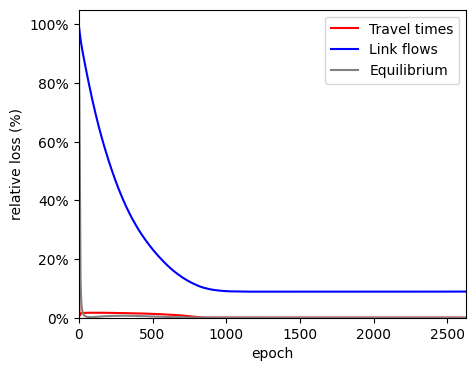

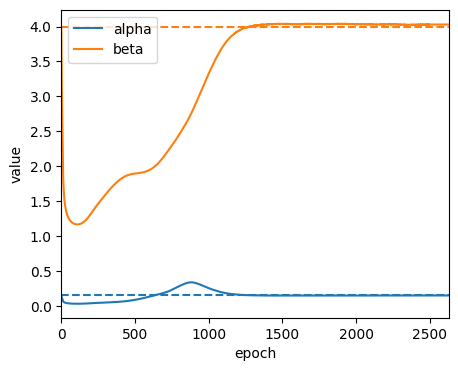

theta = {'tt': array([-1. , -1.3, -3. ])}
alpha =  0.15, beta  =  4.03
Avg abs diff of observed and estimated OD:  0.00


In [19]:
if run_model['lpe']:
    print('\nLPE: link performance estimation')

    # _RELATIVE_GAP = 1e-8

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    # optimizer = NGD(learning_rate=_LR)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           initial_values={'tt': -1, 'tt_sd': -1.3, 's': -3, 'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(tntp_network.links)},
                                           trainables={'psc_factor': False, 'fixed_effect': False
                                               , 'tt': False, 'tt_sd': False, 's': False},
                                           )

    utility_parameters.random_initializer((0,0),['tt','tt_sd','s'])

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   # initial_values={'alpha': 1, 'beta': 2},
                                   true_values={'alpha': 0.15, 'beta': 4},
                                   trainables=dict.fromkeys(['alpha', 'beta'], True),
                                   # trainables={'alpha': False, 'beta': True}
                                   )

    bpr_parameters.random_initializer((0,0),['alpha','beta'])


    od_parameters = ODParameters(key='od',
                                 initial_values= isl.networks.denseQ(Q).flatten(),
                                 # historic_values={0: isl.networks.denseQ(Q).flatten()},
                                 trainable=False)

    equilibrator = Equilibrator(
        network=tntp_network,
        # paths_generator=paths_generator,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    lpe = GISUELOGIT(
        key='lpe',
        network=tntp_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    train_results_dfs['lpe'], val_results_dfs['lpe'] = lpe.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        loss_metric=_LOSS_METRIC,
        # loss_metric=mnrmse,
        # generalization_error={'train': False, 'validation': True},
        loss_weights= dict(_LOSS_WEIGHTS, od = 0),
        momentum_equilibrium = _MOMENTUM_EQUILIBRIUM,
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    train_results_estimates, train_results_losses = lpe.split_results(results=train_results_dfs['lpe'])
    val_results_estimates, val_results_losses = lpe.split_results(results=val_results_dfs['lpe'])

    plot_predictive_performance(train_losses= train_results_losses, val_losses=val_results_dfs['lpe'],
                                show_validation=False,
                                xticks_spacing = _XTICKS_SPACING)

    plot_convergence_estimates(estimates=train_results_estimates[['epoch','alpha','beta']],
                               true_values=lpe.bpr.true_values, xticks_spacing = _XTICKS_SPACING)

    plt.show()

    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(lpe.theta.numpy())))}")
    print(f"alpha = {lpe.alpha: 0.2f}, beta  = {lpe.beta: 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(lpe.q - tntp_network.q.flatten())): 0.2f}")

### Model 4: Estimation of utility function (LUE)


LUE: Estimation of utility function

Epoch: 0/2500, n_periods: 1,  n_timepoints: 100, coverage t, x: [0.75 0.75]
0: train_loss=nan, val_loss=nan, train_loss tt=3.7e+03, val_loss tt=0, train_loss flow=1.4e+07, val_loss flow=0, theta = [-1.  -1.3 -3. ], avg rr = 1.30, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss prop od=nan, loss ntrips=0, total trips=[3.6e+05], lambda eq=1, relative x=0.82, relative gap=1e-10, train flow equilibrium loss=7.7e+07, time: 0.3

Epoch: 1/2500, n_periods: 1,  n_timepoints: 100, coverage t, x: [0.75 0.75]
1: train_loss=nan, val_loss=nan, train_loss tt=3.7e+03, val_loss tt=0, train_loss flow=1.4e+07, val_loss flow=0, theta = [-0.93 -1.37 -3.07], avg rr = 1.47, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss prop od=nan, loss ntrips=0, total trips=[3.6e+05], lambda eq=0.25, relative x=0.81, relative gap=0.049, train flow equilibrium loss=7.6e+07, time: 0.8

Epoch: 100/2500, n_periods: 1,  n_timepo

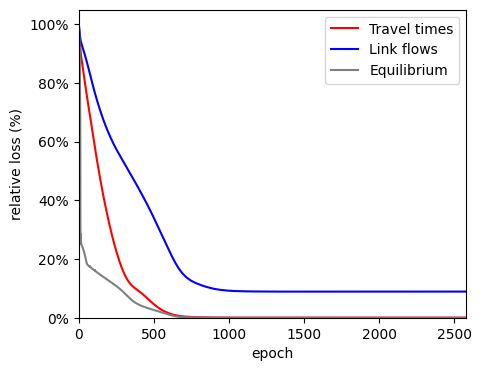

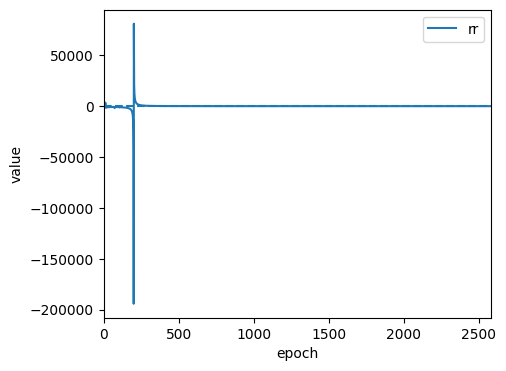

In [20]:
if run_model['lue']:
    print('\nLUE: Estimation of utility function')
    # Initialize again the optimizer as there are some decay parameters that are stored in the object and that will
    # affect the next model estimation
    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    # _RELATIVE_GAP = 1e-8

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           initial_values={'tt': 0, 'tt_sd': 0, 's': 0, 'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(tntp_network.links)},
                                           true_values={'tt': -1, 'tt_sd': -1.3, 's': -3},
                                           trainables={'psc_factor': False, 'fixed_effect': False
                                               , 'tt': True, 'tt_sd': True, 's': True},
                                           )

    # Utility parameters are set equal to their true values
    utility_parameters.random_initializer((0,0),['tt','tt_sd','s'])
    # utility_parameters.initial_values = dict(utility_parameters.initial_values, tt = -1, c = -1, s = -1)

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 4},
                                   # initial_values={'alpha': 1, 'beta': 1},
                                   trainables=dict.fromkeys(['alpha', 'beta'], False))

    od_parameters = ODParameters(key='od',
                                 initial_values= isl.networks.denseQ(Q).flatten(),
                                 # historic_values={0: isl.networks.denseQ(Q_historic).flatten()},
                                 trainable=False)
    equilibrator = Equilibrator(
        network=tntp_network,
        # paths_generator=paths_generator,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    lue = GISUELOGIT(
        key='lue',
        # endogenous_flows=True,
        network=tntp_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        # column_generator=column_generator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters
    )

    train_results_dfs['lue'], val_results_dfs['lue'] = lue.train(
        X_train, Y_train, X_test, Y_test,
        # generalization_error={'train': False, 'validation': True},
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        loss_metric=_LOSS_METRIC,
        loss_weights= dict(_LOSS_WEIGHTS),
        momentum_equilibrium = _MOMENTUM_EQUILIBRIUM,
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    train_results_estimates, train_results_losses = lue.split_results(results=train_results_dfs['lue'])
    val_results_estimates, val_results_losses = lue.split_results(results=val_results_dfs['lue'])

    plot_predictive_performance(train_losses=train_results_losses, val_losses=val_results_losses,
                                show_validation=False, xticks_spacing=_XTICKS_SPACING)

    plot_convergence_estimates(estimates=train_results_estimates.\
                               assign(rr = train_results_estimates['tt_sd']/train_results_estimates['tt'])[['epoch','rr']],
                               true_values={'rr':lue.utility.true_values['tt_sd']/lue.utility.true_values['tt']},
                                xticks_spacing=_XTICKS_SPACING)


    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(lue.theta.numpy())))}, "
          f"rr = {train_results_estimates.eval('tt_sd/tt').values[-1]:0.2f}")
    print(f"alpha = {lue.alpha: 0.2f}, beta  = {lue.beta: 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(lue.q - tntp_network.q.flatten())): 0.2f}")

### Model 5: OD + utility estimation (ODLUE)


ODLUE: OD + utility estimation 

Epoch: 0/2500, n_periods: 1,  n_timepoints: 100, coverage t, x: [0.75 0.75]
0: train_loss=9.1e+07, val_loss=0, train_loss tt=3.7e+03, val_loss tt=0, train_loss flow=1.4e+07, val_loss flow=0, theta = [-1.  -1.3 -3. ], avg rr = 1.30, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss prop od=3.9e+03, loss ntrips=1.8e+03, total trips=[3.6e+05], lambda eq=1, relative x=0.82, relative gap=1e-10, train flow equilibrium loss=7.7e+07, time: 0.5

Epoch: 1/2500, n_periods: 1,  n_timepoints: 100, coverage t, x: [0.75 0.75]
1: train_loss=2.2e+07, val_loss=0, train_loss tt=3.7e+03, val_loss tt=0, train_loss flow=1.4e+07, val_loss flow=0, theta = [-0.93 -1.37 -3.07], avg rr = 1.47, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss prop od=4e+03, loss ntrips=9.4e+03, total trips=[3.6e+05], lambda eq=0.25, relative x=0.81, relative gap=0.063, train flow equilibrium loss=7.6e+07, time: 1.2

Epoch: 100/2500, n_per

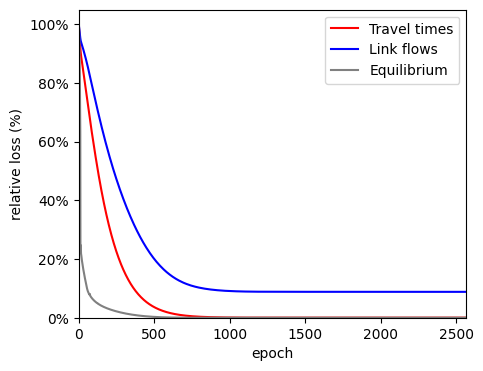

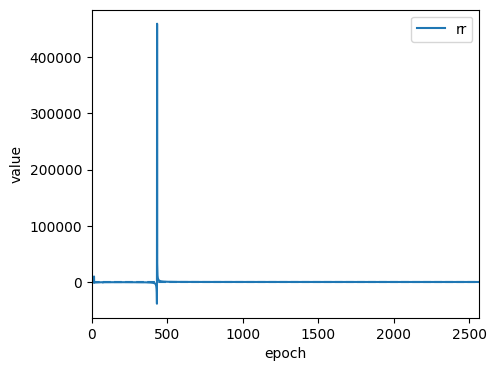

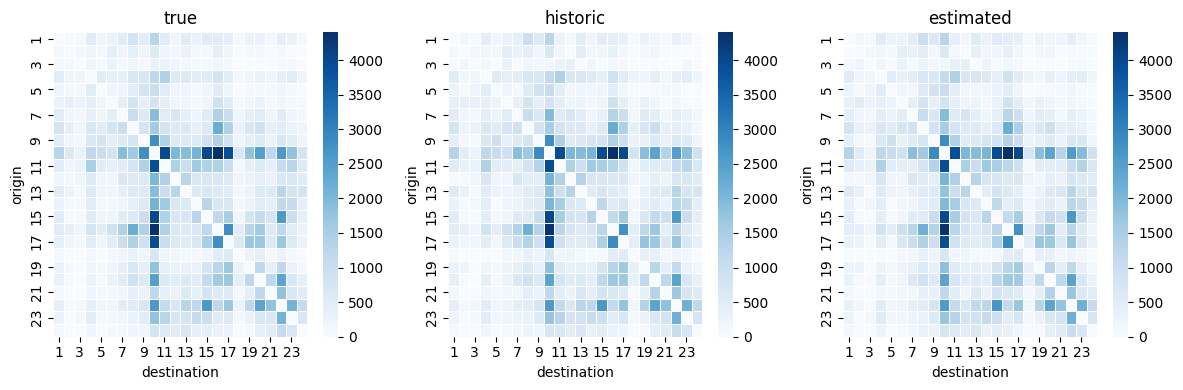

theta = {'tt': array([-0.7805, -1.0709, -2.4743])}, rr = 1.37
alpha =  0.15, beta  =  4.00
Avg abs diff of observed and estimated OD:  51.79


In [21]:
if run_model['odlue']:
    print('\nODLUE: OD + utility estimation ')

    # _RELATIVE_GAP = 1e-7

    # optimizer = tf.keras.optimizers.Adagrad(learning_rate=_LR)

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           initial_values={'tt': 0, 'tt_sd': 0, 's': 0, 'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(tntp_network.links)},
                                           true_values={'tt': -1, 'tt_sd': -1.3, 's': -3},
                                           # signs={'tt': '-', 'tt_sd': '-', 's': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': False
                                               , 'tt': True, 'tt_sd': True, 's': True},
                                           )

    utility_parameters.random_initializer((0,0),['tt','tt_sd','s'])
    # utility_parameters.initial_values = dict(utility_parameters.initial_values, tt = -1, c = -1, s = -1)

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 4},
                                   true_values={'alpha': 0.15, 'beta': 4},
                                   trainables=dict.fromkeys(['alpha', 'beta'], False),
                                   )

    od_parameters = ODParameters(key='od',
                                 initial_values= isl.networks.denseQ(Q).flatten(),
                                 historic_values={0: isl.networks.denseQ(Q_historic).flatten()},
                                 total_trips = {0: np.sum(Q_historic)},
                                 trainable=True)

    equilibrator = Equilibrator(
        network=tntp_network,
        # paths_generator=paths_generator,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    odlue = GISUELOGIT(
        key='odlue',
        network=tntp_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    train_results_dfs['odlue'], val_results_dfs['odlue'] = odlue.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        loss_metric=_LOSS_METRIC,
        # generalization_error={'train': False, 'validation': True},
        loss_weights= dict(_LOSS_WEIGHTS),
        momentum_equilibrium = _MOMENTUM_EQUILIBRIUM,
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    train_results_estimates, train_results_losses = odlue.split_results(results=train_results_dfs['odlue'])
    val_results_estimates, val_results_losses = odlue.split_results(results=val_results_dfs['odlue'])

    plot_predictive_performance(train_losses= train_results_losses, val_losses=val_results_dfs['odlue'],
                                show_validation= False, xticks_spacing = _XTICKS_SPACING)

    plot_convergence_estimates(estimates=train_results_estimates.\
                               assign(rr = train_results_estimates['tt_sd']/train_results_estimates['tt'])[['epoch','rr']],
                               true_values={'rr':odlue.utility.true_values['tt_sd']/odlue.utility.true_values['tt']}, xticks_spacing = _XTICKS_SPACING)

    Qs = {'true': tntp_network.OD.Q_true, 'historic': Q_historic, 'estimated': tf.sparse.to_dense(odlue.Q).numpy()}

    plot_heatmap_demands(Qs=Qs, vmin=np.min(Qs['true']), vmax=np.max(Qs['true']), subplots_dims=(1, 3), figsize=(12, 4))

    plt.show()

    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlue.theta.numpy())))}, "
          f"rr = {train_results_estimates.eval('tt_sd/tt').values[-1]:0.2f}")
    print(f"alpha = {odlue.alpha: 0.2f}, beta  = {odlue.beta: 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlue.q - tntp_network.q.flatten())): 0.2f}")

## Model 6: ODLUE + link specific performance parameters (ODLULPE)


ODLULPE: ODLUE + link performance parameters with historic OD matrix

Epoch: 0/2500, n_periods: 1,  n_timepoints: 100, coverage t, x: [0.75 0.75]
0: train_loss=9.1e+07, val_loss=0, train_loss tt=3.7e+03, val_loss tt=0, train_loss flow=1.4e+07, val_loss flow=0, theta = [-1.  -1.3 -3. ], avg rr = 1.30, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss prop od=3.9e+03, loss ntrips=0, total trips=[3.6e+05], lambda eq=1, relative x=0.82, relative gap=1e-10, train flow equilibrium loss=7.7e+07, time: 0.4

Epoch: 1/2500, n_periods: 1,  n_timepoints: 100, coverage t, x: [0.75 0.75]
1: train_loss=2.1e+07, val_loss=0, train_loss tt=1.3e+03, val_loss tt=0, train_loss flow=1.4e+07, val_loss flow=0, theta = [-0.931 -1.37  -3.069], avg rr = 1.47, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.14, avg beta=3.7, loss prop od=4e+03, loss ntrips=0, total trips=[3.6e+05], lambda eq=0.25, relative x=0.75, relative gap=0.15, train flow equilibrium loss=6.9e+07, time

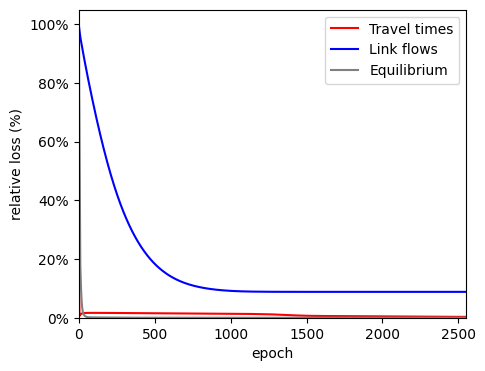

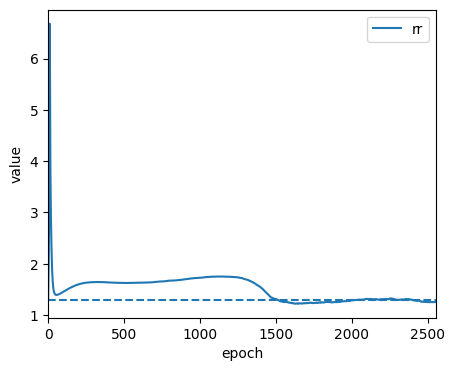

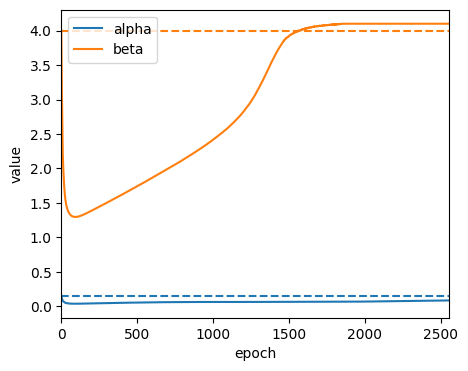

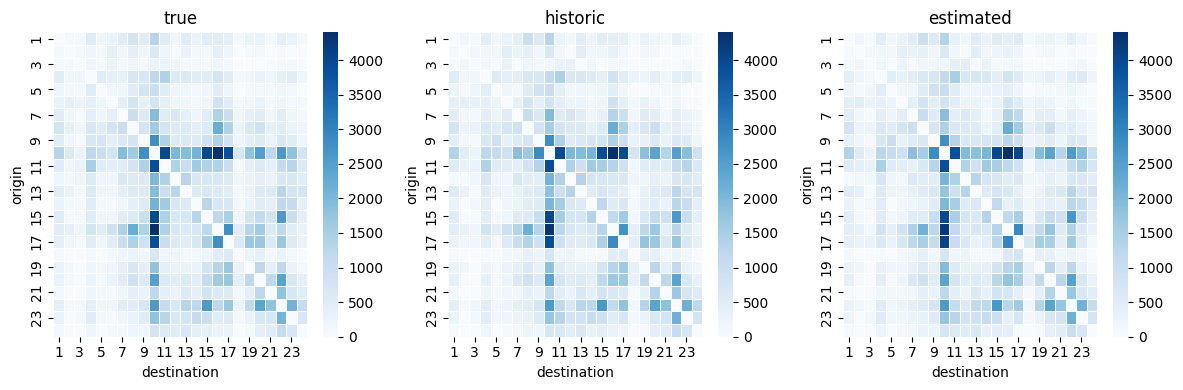

theta = {'tt': array([-1.2893, -1.6162, -2.9591])}, rr = 1.25
alpha =  0.09, beta  =  4.10
Avg abs diff of observed and estimated OD:  64.95


In [22]:
if run_model['odlulpe']:
    # _RELATIVE_GAP = 1e-9
    # Note: convergence of this model requires a learning rate in the order of e-2

    print('\nODLULPE: ODLUE + link performance parameters with historic OD matrix')

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 4},
                                   # initial_values={'alpha': 1, 'beta': 2},
                                   # initial_values={'alpha': np.ones_like(tntp_network.links, dtype=np.float32),
                                   #                 'beta': 4 * np.ones_like(tntp_network.links, dtype=np.float32)},
                                   true_values={'alpha': 0.15, 'beta': 4},
                                   # initial_values={'alpha': 0.15, 'beta': 4},
                                   trainables={'alpha': True, 'beta':True},
                                   )

    bpr_parameters.random_initializer((0,0),['alpha','beta'])
    # bpr_parameters.random_initializer((-0.15, 0.15), ['alpha']))

    od_parameters = ODParameters(key='od',
                                 initial_values=isl.networks.denseQ(Q).flatten(),
                                 historic_values={0: isl.networks.denseQ(Q_historic).flatten()},
                                 trainable=True)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           initial_values={'tt': 0, 'tt_sd': 0, 's': 0, 'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(tntp_network.links)},
                                           true_values={'tt': -1, 'tt_sd': -1.3, 's': -3},
                                           # signs={'tt': '-', 'tt_sd': '-', 's': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': False
                                               , 'tt': True, 'tt_sd': True, 's': True},
                                           )

    utility_parameters.random_initializer((0,0),['tt','tt_sd','s'])
    # utility_parameters.initial_values = dict(utility_parameters.initial_values, tt = -1, c = -1, s = -1)

    equilibrator = Equilibrator(
        network=tntp_network,
        # paths_generator=paths_generator,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    odlulpe = GISUELOGIT(
        key='odlulpe',
        network=tntp_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    train_results_dfs['odlulpe'], val_results_dfs['odlulpe'] = odlulpe.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        # generalization_error={'train': False, 'validation': True},
        batch_size=_BATCH_SIZE,
        loss_weights= dict(_LOSS_WEIGHTS),
        loss_metric=_LOSS_METRIC,
        momentum_equilibrium = _MOMENTUM_EQUILIBRIUM,
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    train_results_estimates, train_results_losses = odlulpe.split_results(results=train_results_dfs['odlulpe'])
    val_results_estimates, val_results_losses = odlulpe.split_results(results=val_results_dfs['odlulpe'])

    print('')
    print(compute_insample_outofsample_error(Y=Y_train,
                                         true_counts=df.true_counts.values[0:tntp_network.get_n_links()],
                                         true_traveltimes=df.true_traveltime.values[0:tntp_network.get_n_links()],
                                         model=odlulpe))

    plot_predictive_performance(train_losses= train_results_losses, val_losses=val_results_dfs['odlulpe'],
                                show_validation=False, xticks_spacing = _XTICKS_SPACING)


    plot_convergence_estimates(estimates=train_results_estimates.\
                               assign(rr = train_results_estimates['tt_sd']/train_results_estimates['tt'])[['epoch','rr']],
                               true_values={'rr':odlulpe.utility.true_values['tt_sd']/odlulpe.utility.true_values['tt']},
                               xticks_spacing = _XTICKS_SPACING)

    plot_convergence_estimates(estimates=train_results_estimates[['epoch','alpha','beta']],
                               true_values=odlulpe.bpr.true_values,
                               xticks_spacing = _XTICKS_SPACING)

    Qs = {'true': tntp_network.OD.Q_true, 'historic': Q_historic, 'estimated': tf.sparse.to_dense(odlulpe.Q).numpy()}

    plot_heatmap_demands(Qs=Qs, vmin=np.min(Qs['true']), vmax=np.max(Qs['true']), subplots_dims=(1, 3), figsize=(12, 4))

    plt.show()

    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlulpe.theta.numpy())))}, "
          f"rr = {train_results_estimates.eval('tt_sd/tt').values[-1]:0.2f}")
    print(f"alpha = {np.mean(odlulpe.alpha): 0.2f}, beta  = {np.mean(odlulpe.beta): 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlulpe.q - tntp_network.q.flatten())): 0.2f}")

## Model 7: ODLULPE without equilibrium condition


ODLULPE with no equilibrium component

Epoch: 0/2500, n_periods: 1,  n_timepoints: 100, coverage t, x: [0.75 0.75]
0: train_loss=3.2e+07, val_loss=0, train_loss tt=1.4e+04, val_loss tt=0, train_loss flow=3.2e+07, val_loss flow=0, theta = [-1.  -1.3 -3. ], avg rr = 1.30, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss prop od=3.9e+03, loss ntrips=0, total trips=[3.6e+05], lambda eq=0, relative x=0.82, relative gap=1e-10, train tt equilibrium loss=1.6e+04, train flow equilibrium loss=7.7e+07, time: 0.3

Epoch: 1/2500, n_periods: 1,  n_timepoints: 100, coverage t, x: [0.75 0.75]
1: train_loss=7.1e+06, val_loss=0, train_loss tt=3.9e+03, val_loss tt=0, train_loss flow=2.8e+07, val_loss flow=0, theta = [-0.93  -1.369 -3.069], avg rr = 1.47, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.14, avg beta=3.7, loss prop od=3.9e+03, loss ntrips=0, total trips=[3.6e+05], lambda eq=0, relative x=0.76, relative gap=0.14, train tt equilibrium loss=5e+03, train

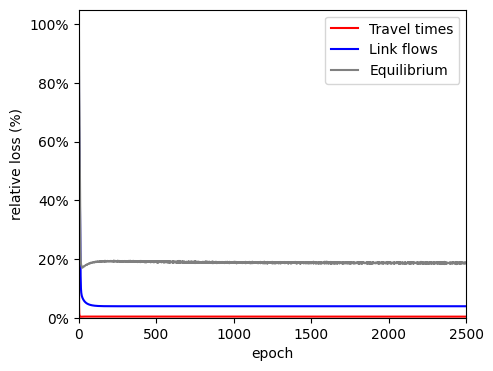

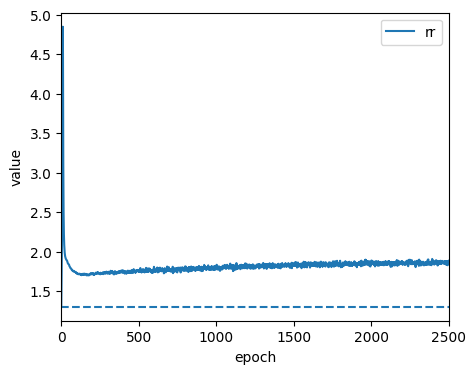

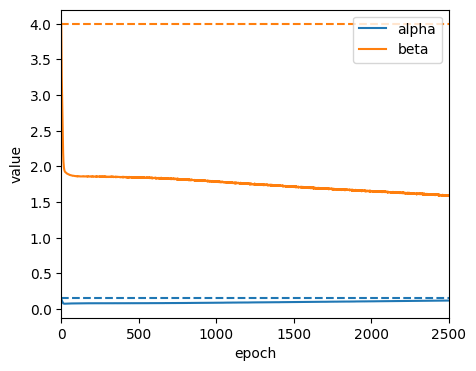

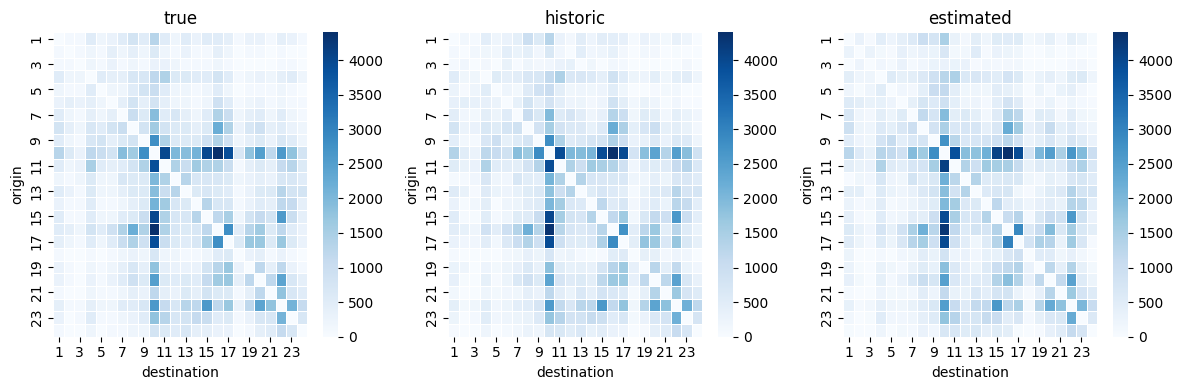

In [23]:
if run_model['odlulpe-no-equilibrium']:
    # _RELATIVE_GAP = 1e-9

    print('\nODLULPE with no equilibrium component')

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 4},
                                   # initial_values={'alpha': 1, 'beta': 2},
                                   # initial_values={'alpha': np.ones_like(tntp_network.links, dtype=np.float32),
                                   #                 'beta': 4 * np.ones_like(tntp_network.links, dtype=np.float32)},
                                   true_values={'alpha': 0.15, 'beta': 4},
                                   # initial_values={'alpha': 0.15, 'beta': 4},
                                   trainables={'alpha': True, 'beta':True},
                                   )

    bpr_parameters.random_initializer((0,0),['alpha','beta'])
    # bpr_parameters.random_initializer((-0.15, 0.15), ['alpha'])

    od_parameters = ODParameters(key='od',
                                 initial_values=isl.networks.denseQ(Q).flatten(),
                                 historic_values={0: isl.networks.denseQ(Q_historic).flatten()},
                                 trainable=True)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           initial_values={'tt': 0, 'tt_sd': 0, 's': 0, 'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(tntp_network.links)},
                                           true_values={'tt': -1, 'tt_sd': -1.3, 's': -3},
                                           # signs={'tt': '-', 'tt_sd': '-', 's': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': False
                                               , 'tt': True, 'tt_sd': True, 's': True},
                                           )

    utility_parameters.random_initializer((0,0),['tt','tt_sd','s'])
    # utility_parameters.initial_values = dict(utility_parameters.initial_values, tt = -1, c = -1, s = -1)

    equilibrator = Equilibrator(
        network=tntp_network,
        # paths_generator=paths_generator,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    odlulpe_no_equilibrium = GISUELOGIT(
        key='odlulpe-no-equilibrium',
        network=tntp_network,
        dtype=tf.float64,
        endogenous_flows=False,
        equilibrator=equilibrator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    train_results_dfs['odlulpe-no-equilibrium'], val_results_dfs['odlulpe-no-equilibrium'] \
        = odlulpe_no_equilibrium.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        loss_weights= dict(_LOSS_WEIGHTS, eq_flow = 0, bpr = 1),
        loss_metric=_LOSS_METRIC,
        momentum_equilibrium=_MOMENTUM_EQUILIBRIUM,
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs= dict(_EPOCHS, equilibrium = 0)
    )

    train_results_estimates, train_results_losses \
        = odlulpe_no_equilibrium.split_results(results=train_results_dfs['odlulpe-no-equilibrium'])
    val_results_estimates, val_results_losses \
        = odlulpe_no_equilibrium.split_results(results=val_results_dfs['odlulpe-no-equilibrium'])

    print('')
    print(compute_insample_outofsample_error(Y=Y_train,
                                             true_counts=df.true_counts.values[0:tntp_network.get_n_links()],
                                             true_traveltimes=df.true_traveltime.values[0:tntp_network.get_n_links()],
                                             model=odlulpe_no_equilibrium))

    plot_predictive_performance(train_losses= train_results_losses,
                                val_losses =val_results_dfs['odlulpe-no-equilibrium'],
                                xticks_spacing = _XTICKS_SPACING)

    plot_convergence_estimates(estimates=
                               train_results_estimates.assign(
                                   rr = train_results_estimates['tt_sd']/train_results_estimates['tt'])[['epoch','rr']],
                               true_values={'rr':odlulpe_no_equilibrium.utility.true_values['tt_sd']
                                                 /odlulpe_no_equilibrium.utility.true_values['tt']},
                               xticks_spacing = _XTICKS_SPACING)

    plot_convergence_estimates(estimates=train_results_estimates[['epoch','alpha','beta']],
                               true_values=odlulpe_no_equilibrium.bpr.true_values,
                               xticks_spacing = _XTICKS_SPACING)

    Qs = {'true': tntp_network.OD.Q_true, 'historic': Q_historic, 'estimated': tf.sparse.to_dense(odlulpe_no_equilibrium.Q).numpy()}

    plot_heatmap_demands(Qs=Qs, vmin=np.min(Qs['true']), vmax=np.max(Qs['true']), subplots_dims=(1, 3), figsize=(12, 4))

    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlulpe_no_equilibrium.theta.numpy())))}, "
          f"rr = {train_results_estimates.eval('tt_sd/tt').values[-1]:0.2f}")
    print(f"alpha = {np.mean(odlulpe_no_equilibrium.alpha): 0.2f}, "
          f"beta  = {np.mean(odlulpe_no_equilibrium.beta): 0.2f}")
    print(f"Avg abs diff between observed and estimated OD: "
          f"{np.mean(np.abs(odlulpe_no_equilibrium.q - tntp_network.q.flatten())): 0.2f}")

## Write predictions

In [24]:
predictions = pd.DataFrame({'link_key': list(tntp_network.links_keys) * Y_train.shape[0],
                            'observed_traveltime': Y_train[:, :, 0].numpy().flatten(),
                            'observed_flow': Y_train[:, :, 1].numpy().flatten()})

predictions['period'] = df.period

for model in [lue,ode, odlue,odlulpe,odlulpe_no_equilibrium]:

    model = odlulpe_no_equilibrium

    predicted_flows = model.flows()
    predicted_traveltimes = model.traveltimes()

    predictions['predicted_traveltime_' + model.key] = np.tile(predicted_traveltimes, (Y_train.shape[0], 1)).flatten()
    predictions['predicted_flow_' + model.key] = np.tile(predicted_flows, (Y_train.shape[0], 1)).flatten()

predictions.to_csv(f"./output/tables/{datetime.now().strftime('%y%m%d%H%M%S')}_train_predictions_{network_name}.csv")

## Write with estimation results

In [25]:
train_results_df, val_results_df \
    = map(lambda x: pd.concat([results.assign(model = model)[['model'] + list(results.columns)]
                               for model, results in x.items()],axis = 0), [train_results_dfs, val_results_dfs])

train_filename = f"{datetime.now().strftime('%y%m%d%H%M%S')}_train_results_{network_name}.csv"
val_filename = f"{datetime.now().strftime('%y%m%d%H%M%S')}_validation_results_{network_name}.csv"
train_results_df.to_csv(f"./output/tables/{train_filename}")
print(f'File {train_filename} was written')
val_results_df.to_csv(f"./output/tables/{val_filename}")
print(f'File {val_filename} was written')

File 230213162512_train_results_SiouxFalls.csv was written
File 230213162512_validation_results_SiouxFalls.csv was written


## Summary of models parameters

In [26]:
models = [lue,odlue,odlulpe]
results = pd.DataFrame({'parameter': [], 'model': []})

for model in models:
    results = results.append(pd.DataFrame(
        {'parameter': ['tt'] + features_Z+
                      ['rr']+
                      ['fixed_effect_mean', 'fixed_effect_std',
                       'alpha_mean', 'alpha_std',
                       'beta_mean', 'beta_std',
                       'od_mean', 'od_std',],
         'values': list(np.mean(model.theta.numpy(),axis =0)) +
                   [float(model.get_parameters_estimates().eval('tt_sd/tt'))] +
                   [np.mean(model.fixed_effect),np.std(model.fixed_effect),
                    np.mean(model.alpha),np.std(model.alpha),
                    np.mean(model.beta),np.std(model.beta),
                    np.mean(model.q),np.std(model.q)]}).\
                             assign(model = model.key)
                             )

In [27]:
results.pivot_table(index = ['parameter'], columns = 'model', values = 'values', sort=False).round(4)

model,lue,odlue,odlulpe
parameter,,,
tt,-0.9812,-0.7805,-1.2893
tt_sd,-1.5535,-1.0709,-1.6162
s,-2.7902,-2.4743,-2.9591
rr,1.5833,1.3721,1.2535
fixed_effect_mean,0.0000,0.0000,0.0000
fixed_effect_std,0.0000,0.0000,0.0000
alpha_mean,0.1500,0.1500,0.0854
alpha_std,0.0000,0.0000,0.0000
beta_mean,4.0000,4.0000,4.1000


## Summary of models goodness of fit

In [28]:
results_losses = pd.DataFrame({})
loss_columns = ['loss_flow', 'loss_tt', 'loss_eq_flow', 'loss_total']

for i, model in enumerate(models):

    results_losses_model = model.split_results(train_results_dfs[model.key])[1].assign(model = model.key)
    results_losses_model = results_losses_model[results_losses_model.epoch == _EPOCHS['learning']].iloc[[0]]
    results_losses = results_losses.append(results_losses_model)

results_losses[loss_columns] = (results_losses[loss_columns]-1)*100

In [29]:
results_losses[['model'] + loss_columns].round(1)

,model,loss_flow,loss_tt,loss_eq_flow,loss_total
2500,lue,-91.1,-100.0,-100.0,NaN
2500,odlue,-91.2,-100.0,-100.0,-99.9
2500,odlulpe,-91.2,-99.7,-100.0,-99.9


## Plot of convergence toward true rr across models

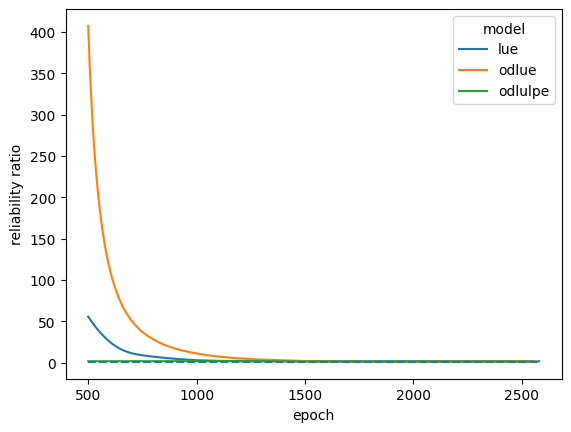

In [30]:
models = [lue,odlue,odlulpe]

train_estimates = {}
train_losses = {}

for model in models:
    train_estimates[model.key], train_losses[model.key] = model.split_results(results=train_results_dfs[model.key])

    train_estimates[model.key]['model'] = model.key

train_estimates_df = pd.concat(train_estimates.values())

train_estimates_df['rr'] = train_estimates_df['tt_sd']/train_estimates_df['tt']

estimates = train_estimates_df[['epoch','model','rr']].reset_index().drop('index',axis = 1)
estimates = estimates[estimates.epoch >=500]

fig, ax = plt.subplots(nrows=1, ncols=1)

g = sns.lineplot(data=estimates, x='epoch', hue='model', y='rr')

ax.hlines(y=compute_rr(utility_parameters.true_values), xmin=estimates['epoch'].min(), xmax=estimates['epoch'].max(), linestyle='--', label = 'truth')

ax.set_ylabel('reliability ratio')

ax.set_xticks(np.arange(estimates['epoch'].min(), estimates['epoch'].max() + 1, _XTICKS_SPACING))

#ax.set_yscale('log')
#plt.ylim(ymin=0)